# Comparing trends across datasets

This notebook uses the "hard seed" trend identified by Heuser and Le-Khac as a touchstone to explore differences between datasets.

The actual counting of words is done by a script in the /get_EF folder: stanfordratiofeaturejsons.py. That produces some summary tsvs stored in the /data folder.

Here we read those files and pair them with metadata in order to visualize trends.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import seaborn as sns
import warnings

### First, let's establish the size of the first difference to be explored.

We're going to contrast the manual_title_subset with and without a bunch of noisy volumes that aren't fiction for adults. What's the size of that difference?

In [2]:
meta = pd.read_csv('../manuallists/manual_title_subset.tsv', sep = '\t',
                   index_col = 'docid')

In [3]:
len(meta)

2730

In [4]:
len(meta.loc[(meta.category == 'longfiction') |
            (meta.category == 'shortfiction')])

2348

In [5]:
(2730-2348) / 2730

0.13992673992673993

In [6]:
len(meta.loc[(meta.category == 'poetry') |
            (meta.category == 'drama')]) / 2730

0.008424908424908424

In [7]:
len(meta.loc[(meta.category == 'notfiction')]) / 2730

0.07728937728937729

In [8]:
len(meta.loc[(meta.category == 'juvenile')]) / 2730

0.054212454212454214

So 14% of the dataset is nonfiction, poetry, drama, or juvenile fiction. Now let's see how much difference that makes to our results.

### Define scatterplots

Let's define a function that returns dates and percentages of Stanford "hard seeds" for all the volumes in a particular dataset. We want to be able to specify the kind of date used (e.g. first publication or latest possible date of composition). We also want to be able to specify the categories included.

In [9]:
def stanfordscatter(stanfile, metafile, datecategory, categories2include):
    x = []
    y = []
    stanpath = '../data/' + stanfile
    stan = pd.read_csv(stanpath, sep = '\t', index_col = 'docid')
    stan['ratio'] = (stan.stanfordwords / stan.allwords)
    metapath = '../manuallists/' + metafile
    meta = pd.read_csv(metapath, sep = '\t', index_col = 'docid')
    meta = meta[~meta.index.duplicated(keep='first')]
    stan = stan[~stan.index.duplicated(keep='first')]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        aligned = pd.concat([meta[datecategory], meta['category'], stan.ratio], axis = 1)
        # I don't want a tiresome warning about sorting the concat
        
    aligned.dropna(subset = ['ratio'], inplace = True)
    aligned = aligned.loc[aligned['category'].isin(categories2include), : ]
    print(aligned.shape)
    for idx, row in aligned.iterrows():
        x.append(row[datecategory])
        y.append(row.ratio)
        
    return np.array(x), np.array(y)

In [10]:
def subspace_trend(x, y):
    subspace_mask = (x >= 1800) & (x < 1901)
    subspace_x = x[subspace_mask]
    subspace_y = y[subspace_mask]
    z = np.polyfit(subspace_x, subspace_y, 1)
    p = np.poly1d(z)
    line_x = range(1800, 1901, 1)
    return line_x, p(line_x)
    

(2722, 3)


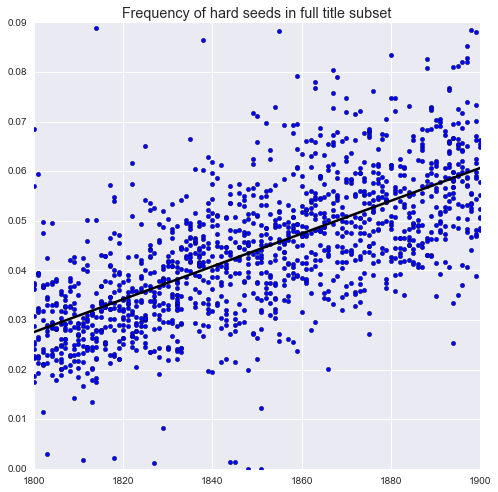

In [11]:
sns.set_style("darkgrid")
all_x, all_y = stanfordscatter('newmanualtitlestanford.tsv', 'manual_title_subset.tsv',
                       'latestcomp', {'drama', 'juvenile', 'longfiction',
                                      'notfiction', 'poetry', 'shortfiction'})
plt.figure(figsize = (8,8))
plt.ylim(0, 0.09)
plt.xlim(1800, 1900)
sns.set(font_scale=1.2)  
plt.scatter(all_x, all_y)
trend_x, trend_y = subspace_trend(all_x, all_y)
plt.plot(trend_x, trend_y,"k", linewidth = 2.5)
plt.title('Frequency of hard seeds in full title subset')
# plt.savefig('../manuallists/figures/stanford/hardtitlescatter.png', bbox_inches = 'tight')
plt.show()

(2342, 3)


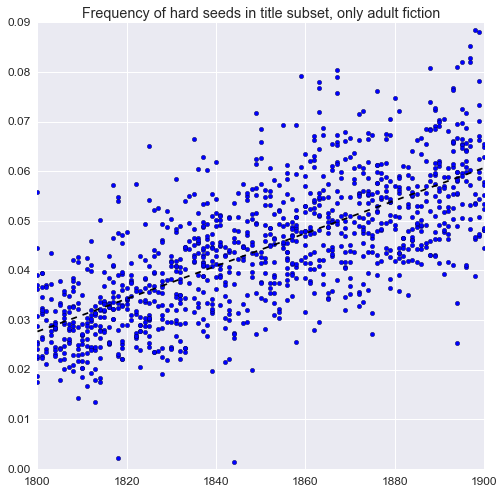

In [12]:
clean_x, clean_y = stanfordscatter('newmanualtitlestanford.tsv', 'manual_title_subset.tsv',
                       'firstpub', {'longfiction', 'shortfiction'})
plt.figure(figsize = (8, 8))
sns.set(font_scale=1.2)  
plt.scatter(clean_x, clean_y)
trend_x, trend_y = subspace_trend(clean_x, clean_y)
plt.plot(trend_x, trend_y,"k--")
plt.ylim(0, 0.09)
plt.xlim(1800, 1900)
plt.title('Frequency of hard seeds in title subset, only adult fiction')
# plt.savefig('../manuallists/figures/stanford/onlynovelscatter.png', bbox_inches = 'tight')
plt.show()

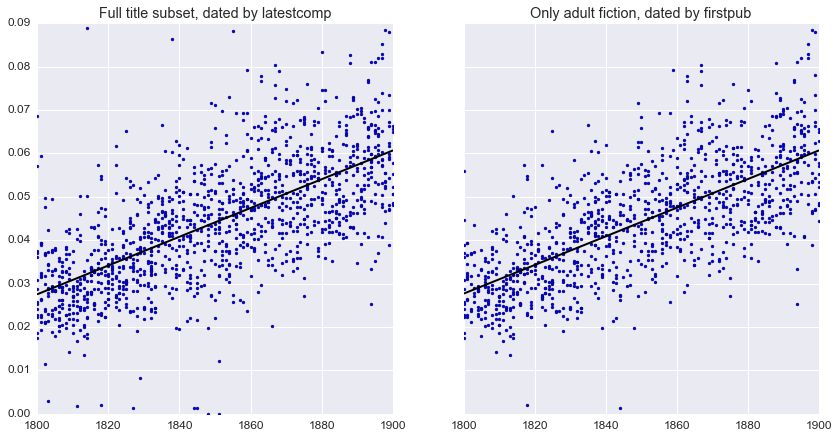

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (14, 7))
ax1.set_ylim(0, 0.09)
ax1.set_xlim(1800, 1900)
ax1.scatter(all_x, all_y, s = 9, marker = 'o')
trend_x, trend_y = subspace_trend(all_x, all_y)
ax1.plot(trend_x, trend_y,"k", linewidth = 2)
ax1.set_title('Full title subset, dated by latestcomp')

ax2.scatter(clean_x, clean_y, s = 9, marker = 'o')
trend2_x, trend2_y = subspace_trend(clean_x, clean_y)
ax2.plot(trend2_x, trend2_y, "k", linewidth = 2)
ax2.set_xlim(1800, 1900)
ax2.set_title('Only adult fiction, dated by firstpub')
plt.savefig('../manuallists/figures/stanford/sidebyside.png', dpi = 400, bbox_inches = 'tight')
plt.show()


In [14]:
print(pearsonr(trend_y, trend2_y))
trend_y - trend2_y

(1.0, 0.0)


array([ -1.15900969e-04,  -1.14868290e-04,  -1.13835611e-04,
        -1.12802932e-04,  -1.11770253e-04,  -1.10737574e-04,
        -1.09704895e-04,  -1.08672217e-04,  -1.07639538e-04,
        -1.06606859e-04,  -1.05574180e-04,  -1.04541501e-04,
        -1.03508822e-04,  -1.02476143e-04,  -1.01443464e-04,
        -1.00410785e-04,  -9.93781064e-05,  -9.83454275e-05,
        -9.73127486e-05,  -9.62800696e-05,  -9.52473907e-05,
        -9.42147118e-05,  -9.31820329e-05,  -9.21493540e-05,
        -9.11166751e-05,  -9.00839962e-05,  -8.90513173e-05,
        -8.80186383e-05,  -8.69859594e-05,  -8.59532805e-05,
        -8.49206016e-05,  -8.38879227e-05,  -8.28552438e-05,
        -8.18225649e-05,  -8.07898860e-05,  -7.97572070e-05,
        -7.87245281e-05,  -7.76918492e-05,  -7.66591703e-05,
        -7.56264914e-05,  -7.45938125e-05,  -7.35611336e-05,
        -7.25284547e-05,  -7.14957758e-05,  -7.04630968e-05,
        -6.94304179e-05,  -6.83977390e-05,  -6.73650601e-05,
        -6.63323812e-05,

In [15]:
def stanfordtrend(stanfile, metafile, categories2include):
    x = []
    y = []
    stanpath = '../data/' + stanfile
    stan = pd.read_csv(stanpath, sep = '\t', index_col = 'docid')
    stan['ratio'] = (stan.stanfordwords / stan.allwords)
    metapath = '../manuallists/' + metafile
    meta = pd.read_csv(metapath, sep = '\t', index_col = 'docid')
    meta = meta[~meta.index.duplicated(keep='first')]
    stan = stan[~stan.index.duplicated(keep='first')]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        aligned = pd.concat([meta.firstpub, meta['category'], stan.ratio], axis = 1)
    aligned.dropna(subset = ['ratio'], inplace = True)
    aligned = aligned.loc[aligned['category'].isin(categories2include), : ]
    for year in range(1800, 2007):
        df = aligned.loc[(aligned.firstpub >= year - 1) & 
                         (aligned.firstpub <= year + 1), : ]
        y.append(np.mean(df.ratio))
        x.append(year)
        
    return x, y

In [16]:
clean_x_trend, clean_y_trend = stanfordtrend('newmanualtitlestanford.tsv', 'manual_title_subset.tsv', {'longfiction', 'shortfiction'})

In [21]:
g_x, g_y = stanfordtrend('newgenderbalancedstanford.tsv', 
                         'gender_balanced_subset.tsv', {'longfiction', 'shortfiction'})

#### additional function for the different "popular" case

The popular metadata is in a different folder, and also lacks a category column.

In [18]:
def stanfordtrend2(stanfile, metafile):
    x = []
    y = []
    stanpath = '../data/' + stanfile
    stan = pd.read_csv(stanpath, sep = '\t', index_col = 'docid')
    stan['ratio'] = (stan.stanfordwords / stan.allwords)
    metapath = metafile
    meta = pd.read_csv(metapath, sep = '\t', index_col = 'docid')
    meta = meta[~meta.index.duplicated(keep='first')]
    stan = stan[~stan.index.duplicated(keep='first')]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        aligned = pd.concat([meta.latestcomp, stan.ratio], axis = 1)
        
    aligned.dropna(subset = ['ratio'], inplace = True)

    for year in range(1800, 2007):
        df = aligned.loc[(aligned.latestcomp >= year - 1) & 
                         (aligned.latestcomp <= year + 1), : ]
        y.append(np.mean(df.ratio))
        x.append(year)
        
    return x, y

In [19]:
p_x, p_y = stanfordtrend2('newpopularstanford.tsv', 'most_popular_subset.tsv')

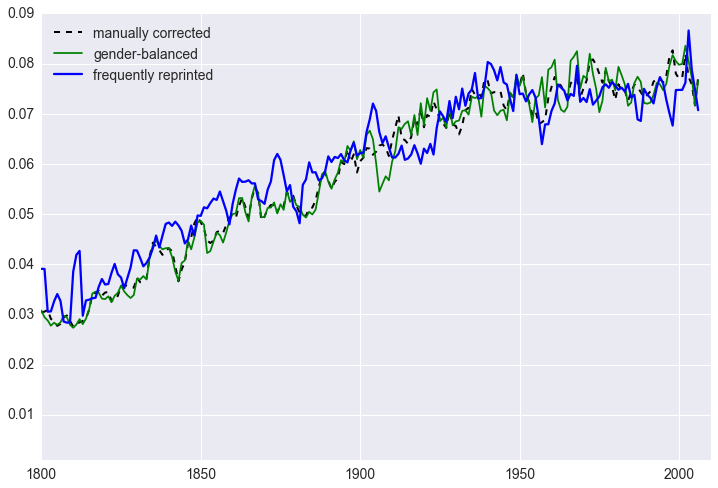

In [22]:
plt.figure(figsize = (12, 8))
plt.plot(clean_x_trend, clean_y_trend, 'k--', linewidth = 2, label = 'manually corrected')
plt.plot(g_x, g_y, color = 'green', label = 'gender-balanced')
plt.plot(p_x, p_y, 'b-', linewidth = 2.25, label = 'frequently reprinted')
plt.ylim(0.001, 0.09)
plt.xlim(1800, 2010)
plt.legend(loc='upper left')
sns.set(font_scale=1.4)
plt.savefig('../manuallists/figures/stanford/comparativetrends.png', dpi = 400, bbox_inches = 'tight')
plt.show()

#### It looks like the frequently-reprinted books are consistently ahead of trend in the 19c

Is that significant?

In [23]:
print(np.mean(p_y[0:100]), np.mean(clean_y_trend[0:100]))

0.0477397174662 0.0439773515756


In [24]:
from scipy.stats import ttest_ind

In [25]:
ttest_ind(p_y[0:100], clean_y_trend[0:100])

Ttest_indResult(statistic=2.6774361226382339, pvalue=0.008041385080274209)

#### yep, it's significant